February 3, 2026


### Model 5 Changes (from Model 4):



##### Multi-Modality


- Input: 4 channels (T1, T1ce, T2, FLAIR) instead of 1
- Model: in_channels=4


##### Performance


- batch_size: 32 → 64
- Mixed precision (AMP): ~2x faster
- tumor_oversample_factor: 5 → 10


##### Fighting Overfitting


- Dropout2d(0.2) in decoder
- weight_decay=1e-5 (L2 regularization)
- ReduceLROnPlateau scheduler
- Intensity augmentation (brightness/contrast)


##### Competition Evaluation


- BraTS regions: WT, TC, ET
- Metrics: Dice + HD95
- Full test set evaluation


#### Expected Results


##### Model 4 (single modality):


- Val Dice: NCR=0.44, ED=0.28, ET=0.49


##### Model 5 targets (multi-modality):


- Val Dice: NCR>0.50, ED>0.50, ET>0.60
- Reduced train/val gap (less overfitting)


# Load Preprocessed Data, split into train/val/test 

In [9]:
import torch
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

from brats_utils import BraTSFastDataset, gpu_augment, create_weighted_sampler

# *** MODEL 5 ***: Same preprocessed directory, but now contains 4 modalities
# Run: python preprocess_to_npy.py --data_root ~/brats-training-data/MICCAI_BraTS2020_TrainingData --output_dir ~/brats-preprocessed --modalities t1 t1ce t2 flair
PREPROCESSED_DIR = Path("/home/sagemaker-user/brats-preprocessed")

train_dataset = BraTSFastDataset(PREPROCESSED_DIR, split='train', augment=False)
validation_dataset = BraTSFastDataset(PREPROCESSED_DIR, split='val', augment=False)
test_dataset = BraTSFastDataset(PREPROCESSED_DIR, split='test', augment=False)

Loaded train dataset: 26152 slices
  → 13241 with tumor (50.6%)
  → 12911 without tumor
Loaded val dataset: 13047 slices
  → 6545 with tumor (50.2%)
  → 6502 without tumor
Loaded test dataset: 8769 slices
  → 4515 with tumor (51.5%)
  → 4254 without tumor


##### Quick Data Visualization - 4 modalities

Image Shape: torch.Size([4, 240, 240])
Mask Shape: torch.Size([240, 240])
Mask dtype: torch.int64
Unique labels in mask: tensor([0, 1, 2, 3])


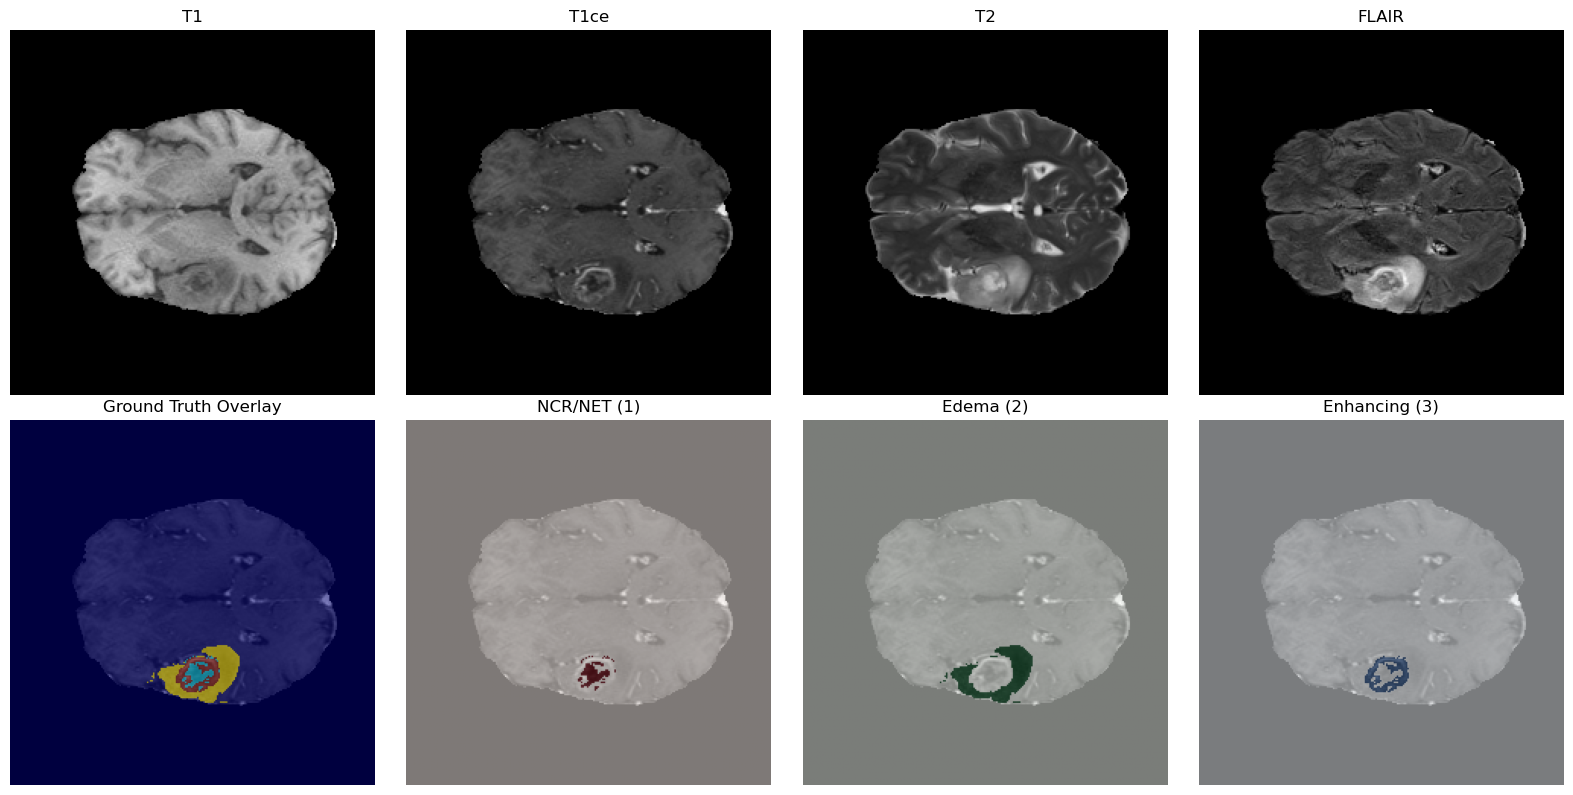

In [10]:
if len(train_dataset) > 0:
    sample_img, sample_mask = train_dataset[1485]

    print(f"Image Shape: {sample_img.shape}")  # *** MODEL 5 ***: Expect (4, 240, 240) - 4 modalities!
    print(f"Mask Shape: {sample_mask.shape}")  # Expect (240, 240)
    print(f"Mask dtype: {sample_mask.dtype}")  # Expect torch.int64
    print(f"Unique labels in mask: {torch.unique(sample_mask)}")

    # *** MODEL 5 NEW ***: Visualize all 4 modalities
    def visualize_multimodality(img_tensor, mask_tensor, modalities=['T1', 'T1ce', 'T2', 'FLAIR']):
        """Visualize all 4 MRI modalities and the segmentation mask"""
        img = img_tensor.numpy()
        mask = mask_tensor.numpy()
        
        fig, axes = plt.subplots(2, 4, figsize=(16, 8))
        
        # Top row: All 4 modalities
        for i, (ax, mod_name) in enumerate(zip(axes[0], modalities)):
            ax.imshow(img[i], cmap='gray')
            ax.set_title(f"{mod_name}")
            ax.axis('off')
        
        # Bottom row: Mask overlays
        # Full mask
        axes[1, 0].imshow(img[1], cmap='gray')  # T1ce as background
        axes[1, 0].imshow(mask, cmap='jet', alpha=0.5, vmin=0, vmax=3)
        axes[1, 0].set_title("Ground Truth Overlay")
        axes[1, 0].axis('off')
        
        # Individual classes
        colors = ['Reds', 'Greens', 'Blues']
        titles = ['NCR/NET (1)', 'Edema (2)', 'Enhancing (3)']
        for i, (ax, color, title) in enumerate(zip(axes[1, 1:], colors, titles)):
            ax.imshow(img[1], cmap='gray')
            class_mask = (mask == i+1).astype(float)
            ax.imshow(class_mask, cmap=color, alpha=0.5)
            ax.set_title(title)
            ax.axis('off')
        
        plt.tight_layout()
        plt.show()

    visualize_multimodality(sample_img, sample_mask)
else:
    print("ERROR: Dataset is empty. Did you run preprocess_to_npy.py with --modalities t1 t1ce t2 flair?")

##### The DataLoader

In [11]:
BATCH_SIZE = 64
NUM_WORKERS = 4
TUMOR_OVERSAMPLE_FACTOR = 10.0

# NOTE: augment=False - we do augmentation on GPU now
train_dataset = BraTSFastDataset(PREPROCESSED_DIR, split='train', augment=False)
validation_dataset = BraTSFastDataset(PREPROCESSED_DIR, split='val', augment=False)
test_dataset = BraTSFastDataset(PREPROCESSED_DIR, split='test', augment=False)

train_sampler = create_weighted_sampler(train_dataset, tumor_oversample_factor=TUMOR_OVERSAMPLE_FACTOR)

train_dataloader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    sampler=train_sampler,
    num_workers=NUM_WORKERS,
    pin_memory=True,
    persistent_workers=True,
    prefetch_factor=4,
)

validation_dataloader = DataLoader(
    validation_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True,
    persistent_workers=True,
    prefetch_factor=4,
)

Loaded train dataset: 26152 slices
  → 13241 with tumor (50.6%)
  → 12911 without tumor
Loaded val dataset: 13047 slices
  → 6545 with tumor (50.2%)
  → 6502 without tumor
Loaded test dataset: 8769 slices
  → 4515 with tumor (51.5%)
  → 4254 without tumor


# The Model: U-NET (Multi-Modality with Dropout)

In [12]:
import torch.nn as nn

class SimpleUNet(nn.Module):
    """
    *** MODEL 5 CHANGES ***:
    - in_channels: 1 → 4 (for 4 MRI modalities)
    - Added Dropout2d in decoder (fights overfitting)
    """
    def __init__(self, in_channels=4, num_classes=4, dropout_rate=0.2):  # *** MODEL 5 ***: in_channels=4, added dropout
        super().__init__()
        
        self.dropout_rate = dropout_rate
        
        # Encoder - *** MODEL 5 ***: First layer now takes 4 input channels
        self.enc1 = nn.Sequential(
            nn.Conv2d(in_channels, 16, 3, padding=1),  # *** MODEL 5 ***: in_channels instead of 1
            nn.ReLU(), 
            nn.Conv2d(16, 16, 3, padding=1), 
            nn.ReLU()
        )
        self.pool1 = nn.MaxPool2d(2, 2)  # 240 -> 120
        
        self.enc2 = nn.Sequential(nn.Conv2d(16, 32, 3, padding=1), nn.ReLU(), nn.Conv2d(32, 32, 3, padding=1), nn.ReLU())
        self.pool2 = nn.MaxPool2d(2, 2)  # 120 -> 60
        
        self.enc3 = nn.Sequential(nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.Conv2d(64, 64, 3, padding=1), nn.ReLU())
        self.pool3 = nn.MaxPool2d(2, 2)  # 60 -> 30

        # Bottleneck
        self.bottleneck = nn.Sequential(nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(), nn.Conv2d(128, 128, 3, padding=1), nn.ReLU())

        # Decoder - *** MODEL 5 ***: Added Dropout2d after each decoder block
        self.up3 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2) 
        self.dec3 = nn.Sequential(nn.Conv2d(128, 64, 3, padding=1), nn.ReLU())
        self.drop3 = nn.Dropout2d(dropout_rate)  # *** MODEL 5 NEW ***

        self.up2 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2) 
        self.dec2 = nn.Sequential(nn.Conv2d(64, 32, 3, padding=1), nn.ReLU())
        self.drop2 = nn.Dropout2d(dropout_rate)  # *** MODEL 5 NEW ***

        self.up1 = nn.ConvTranspose2d(32, 16, kernel_size=2, stride=2) 
        self.dec1 = nn.Sequential(nn.Conv2d(32, 16, 3, padding=1), nn.ReLU())
        self.drop1 = nn.Dropout2d(dropout_rate)  # *** MODEL 5 NEW ***

        self.final = nn.Conv2d(16, num_classes, kernel_size=1)

    def forward(self, x):
        # Encoder
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool1(e1))
        e3 = self.enc3(self.pool2(e2))
        
        # Bottleneck
        b = self.bottleneck(self.pool3(e3))
        
        # Decoder with skip connections and dropout
        d3 = self.up3(b)
        d3 = torch.cat((e3, d3), dim=1) 
        d3 = self.dec3(d3)
        d3 = self.drop3(d3)  # *** MODEL 5 NEW ***
        
        d2 = self.up2(d3)
        d2 = torch.cat((e2, d2), dim=1) 
        d2 = self.dec2(d2)
        d2 = self.drop2(d2)  # *** MODEL 5 NEW ***

        d1 = self.up1(d2)
        d1 = torch.cat((e1, d1), dim=1) 
        d1 = self.dec1(d1)
        d1 = self.drop1(d1)  # *** MODEL 5 NEW ***
        
        return self.final(d1)

##### Quick Shape Check

In [13]:
# *** MODEL 5 ***: Now with in_channels=4 and dropout
model = SimpleUNet(in_channels=4, num_classes=4, dropout_rate=0.2)

# Get a sample batch to test the model
batch_imgs, batch_masks = next(iter(train_dataloader))
predictions = model(batch_imgs).detach()

print(f"Input Shape:      {batch_imgs.shape}")   # (64, 4, 240, 240) - 4 channels!
print(f"Prediction Shape: {predictions.shape}")  # (64, 4, 240, 240) - 4 classes
print(f"Mask Shape:       {batch_masks.shape}")  # (64, 240, 240)

print(f"\n✓ Model accepts 4-channel input (T1, T1ce, T2, FLAIR)")
print(f"✓ Model uses dropout_rate=0.2 for regularization")

Input Shape:      torch.Size([64, 4, 240, 240])
Prediction Shape: torch.Size([64, 4, 240, 240])
Mask Shape:       torch.Size([64, 240, 240])

✓ Model accepts 4-channel input (T1, T1ce, T2, FLAIR)
✓ Model uses dropout_rate=0.2 for regularization


##### Set up Device, Loss, and Optimizer

In [14]:
import torch.optim as optim

# Device setup
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("✓ Using Apple Metal (MPS) Acceleration!")
elif torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"✓ Using NVIDIA CUDA: {torch.cuda.get_device_name(0)}")
else:
    device = torch.device("cpu")
    print("Using CPU (Slower, but works)")

model = model.to(device)

# =============================================================================
# Loss Function: CE + Dice (same as Model 4)
# =============================================================================

class CombinedLoss(nn.Module):
    """
    CrossEntropy + Dice (standard for medical segmentation)
    Same as Model 4 - this worked well
    """
    def __init__(self, num_classes=4, smooth=1e-6):
        super().__init__()
        self.num_classes = num_classes
        self.smooth = smooth
        
        # CE class weights: low for background, high for tumors
        ce_weights = torch.tensor([0.1, 1.0, 1.0, 1.0])
        self.ce = nn.CrossEntropyLoss(weight=ce_weights)
        
    def forward(self, predictions, targets):
        # Move CE weights to correct device
        self.ce.weight = self.ce.weight.to(predictions.device)
        
        # CrossEntropy loss
        ce_loss = self.ce(predictions, targets)
        
        # Dice loss (on tumor classes only)
        probs = torch.softmax(predictions, dim=1)
        targets_one_hot = torch.zeros_like(probs)
        targets_one_hot.scatter_(1, targets.unsqueeze(1), 1)
        
        dice_scores = []
        for c in range(1, self.num_classes):  # Skip background for Dice
            pred_c = probs[:, c, :, :]
            target_c = targets_one_hot[:, c, :, :]
            
            intersection = torch.sum(pred_c * target_c)
            union = torch.sum(pred_c) + torch.sum(target_c)
            
            dice = (2.0 * intersection + self.smooth) / (union + self.smooth)
            dice_scores.append(dice)
        
        dice_loss = 1.0 - torch.mean(torch.stack(dice_scores))
        
        # Combine 50/50
        return 0.5 * ce_loss + 0.5 * dice_loss

criterion = CombinedLoss(num_classes=4)

# *** MODEL 5 ***: Added weight_decay for L2 regularization
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

# *** MODEL 5 NEW ***: Learning rate scheduler
# Reduces LR by factor of 0.5 when validation loss plateaus for 3 epochs
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

print("✓ Loss function: CE + Dice combined")
print("✓ Optimizer: Adam with weight_decay=1e-5 (L2 regularization)")
print("✓ LR Scheduler: ReduceLROnPlateau (factor=0.5, patience=3)")

✓ Using NVIDIA CUDA: Tesla T4
✓ Loss function: CE + Dice combined
✓ Optimizer: Adam with weight_decay=1e-5 (L2 regularization)
✓ LR Scheduler: ReduceLROnPlateau (factor=0.5, patience=3)


# Competition Metrics

In [15]:
# *** MODEL 5 NEW ***: BraTS competition-standard evaluation metrics

from scipy.ndimage import distance_transform_edt
from tqdm.auto import tqdm

def compute_dice(pred, target, smooth=1e-6):
    """Compute Dice coefficient"""
    intersection = np.sum(pred * target)
    union = np.sum(pred) + np.sum(target)
    return (2.0 * intersection + smooth) / (union + smooth)

def compute_hd95(pred, target):
    """
    Compute 95th percentile Hausdorff Distance
    
    HD95 measures the distance between the boundaries of prediction and ground truth.
    Lower is better. Returns inf if either mask is empty.
    """
    if np.sum(pred) == 0 or np.sum(target) == 0:
        return np.inf
    
    # Get boundaries using distance transform
    pred_border = pred ^ distance_transform_edt(pred == 0) <= 1
    target_border = target ^ distance_transform_edt(target == 0) <= 1
    
    # Distance from pred boundary to target
    dt_target = distance_transform_edt(~target.astype(bool))
    dist_pred_to_target = dt_target[pred_border]
    
    # Distance from target boundary to pred
    dt_pred = distance_transform_edt(~pred.astype(bool))
    dist_target_to_pred = dt_pred[target_border]
    
    # Combine all distances
    all_distances = np.concatenate([dist_pred_to_target, dist_target_to_pred])
    
    if len(all_distances) == 0:
        return np.inf
    
    return np.percentile(all_distances, 95)

def compute_brats_regions(mask):
    """
    Convert raw class labels to BraTS competition regions
    
    Raw classes: 0=BG, 1=NCR/NET, 2=ED, 3=ET
    
    BraTS regions:
    - WT (Whole Tumor): 1 + 2 + 3 (all tumor classes)
    - TC (Tumor Core): 1 + 3 (NCR/NET + Enhancing, no edema)
    - ET (Enhancing Tumor): 3 only
    """
    wt = (mask >= 1).astype(np.uint8)  # Classes 1, 2, 3
    tc = ((mask == 1) | (mask == 3)).astype(np.uint8)  # Classes 1 and 3
    et = (mask == 3).astype(np.uint8)  # Class 3 only
    return wt, tc, et

def compute_brats_metrics(pred, target):
    """
    Compute BraTS competition metrics for a single prediction/target pair
    
    Returns dict with Dice and HD95 for WT, TC, ET
    """
    pred_wt, pred_tc, pred_et = compute_brats_regions(pred)
    target_wt, target_tc, target_et = compute_brats_regions(target)
    
    metrics = {
        'WT_Dice': compute_dice(pred_wt, target_wt),
        'TC_Dice': compute_dice(pred_tc, target_tc),
        'ET_Dice': compute_dice(pred_et, target_et),
        'WT_HD95': compute_hd95(pred_wt, target_wt),
        'TC_HD95': compute_hd95(pred_tc, target_tc),
        'ET_HD95': compute_hd95(pred_et, target_et),
    }
    return metrics

def compute_dice_per_class(predictions, targets, num_classes=4, smooth=1e-6):
    """Compute Dice score for each class separately (for monitoring during training)"""
    with torch.no_grad():
        pred_probs = torch.softmax(predictions, dim=1)
        pred_classes = torch.argmax(pred_probs, dim=1)
        
        dice_scores = []
        for c in range(num_classes):
            pred_c = (pred_classes == c).float()
            target_c = (targets == c).float()
            
            intersection = torch.sum(pred_c * target_c)
            union = torch.sum(pred_c) + torch.sum(target_c)

            dice = (2.0 * intersection + smooth) / (union + smooth)
            dice_scores.append(dice.item())
        
        return dice_scores

print("✓ Loaded BraTS competition metrics: WT, TC, ET Dice + HD95")

✓ Loaded BraTS competition metrics: WT, TC, ET Dice + HD95


# The Training Loop

*** MODEL 5 NEW ***: Mixed Precision Training (AMP) + Competition Metrics

In [16]:
from torch.amp import GradScaler, autocast

num_epochs = 15
best_val_loss = float('inf')

# Training history
history = {
    'train_loss': [], 'val_loss': [],
    'train_dice_per_class': [], 'val_dice_per_class': [],
    'learning_rates': []
}

# Mixed precision
use_amp = device.type == 'cuda'
scaler = GradScaler('cuda') if use_amp else None

print("Starting Training...")
print(f"  - Epochs: {num_epochs}")
print(f"  - Batch size: {BATCH_SIZE}")
print(f"  - Training samples: {len(train_dataset)}")
print(f"  - Validation samples: {len(validation_dataset)}")
print(f"  - Mixed Precision (AMP): {use_amp}")
print(f"  - GPU Augmentation: ENABLED (flip + rotate)")
print()

for epoch in range(num_epochs):
    # =========================================================================
    # TRAINING
    # =========================================================================
    model.train()
    running_loss = 0.0
    train_dice_accumulator = [0.0, 0.0, 0.0, 0.0]
    
    current_lr = optimizer.param_groups[0]['lr']
    history['learning_rates'].append(current_lr)
    
    for images, masks in tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]"):
        # Move to GPU
        images = images.to(device, non_blocking=True)
        masks = masks.to(device, non_blocking=True)
        
        # *** GPU AUGMENTATION *** (essentially free!)
        images, masks = gpu_augment(images, masks, p_flip=0.5, p_rotate=0.5, max_angle=15)
        # Alternative: use gpu_augment_fast() for flip-only (even faster)
        # images, masks = gpu_augment_fast(images, masks, p_flip=0.5)
        
        optimizer.zero_grad()
        
        # Mixed precision forward pass
        if use_amp:
            with autocast('cuda'):
                outputs = model(images)
                loss = criterion(outputs, masks)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            outputs = model(images)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()
        
        running_loss += loss.item()
        
        # Track per-class Dice
        dice_scores = compute_dice_per_class(outputs, masks)
        for c in range(4):
            train_dice_accumulator[c] += dice_scores[c]
    
    # Epoch stats
    train_epoch_loss = running_loss / len(train_dataloader)
    train_dice_per_class = [score / len(train_dataloader) for score in train_dice_accumulator]
    history['train_loss'].append(train_epoch_loss)
    history['train_dice_per_class'].append(train_dice_per_class)
    
    print(f"\nTrain Epoch [{epoch+1}/{num_epochs}] (LR: {current_lr:.2e})")
    print(f"  Loss: {train_epoch_loss:.4f}")
    print(f"  Dice per class - BG: {train_dice_per_class[0]:.4f}, NCR: {train_dice_per_class[1]:.4f}, ED: {train_dice_per_class[2]:.4f}, ET: {train_dice_per_class[3]:.4f}")
    
    # =========================================================================
    # VALIDATION (no augmentation)
    # =========================================================================
    model.eval()
    validation_running_loss = 0.0
    val_dice_accumulator = [0.0, 0.0, 0.0, 0.0]
    
    with torch.no_grad():
        for images, masks in tqdm(validation_dataloader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]"):
            images = images.to(device, non_blocking=True)
            masks = masks.to(device, non_blocking=True)
            
            # NO augmentation for validation
            
            if use_amp:
                with autocast('cuda'):
                    outputs = model(images)
                    loss = criterion(outputs, masks)
            else:
                outputs = model(images)
                loss = criterion(outputs, masks)
            
            validation_running_loss += loss.item()
            
            dice_scores = compute_dice_per_class(outputs, masks)
            for c in range(4):
                val_dice_accumulator[c] += dice_scores[c]
    
    validation_epoch_loss = validation_running_loss / len(validation_dataloader)
    val_dice_per_class = [score / len(validation_dataloader) for score in val_dice_accumulator]
    history['val_loss'].append(validation_epoch_loss)
    history['val_dice_per_class'].append(val_dice_per_class)

    print(f"Val Epoch [{epoch+1}/{num_epochs}]")
    print(f"  Loss: {validation_epoch_loss:.4f}")
    print(f"  Dice per class - BG: {val_dice_per_class[0]:.4f}, NCR: {val_dice_per_class[1]:.4f}, ED: {val_dice_per_class[2]:.4f}, ET: {val_dice_per_class[3]:.4f}")
    
    # Step the scheduler based on validation loss
    scheduler.step(validation_epoch_loss)
    
    # Save best model
    if validation_epoch_loss < best_val_loss:
        best_val_loss = validation_epoch_loss
        torch.save(model.state_dict(), 'model5_best.pth')
        print(f"  ✓ Saved best model (val_loss={validation_epoch_loss:.4f})")

# Save final model
torch.save(model.state_dict(), 'model5_checkpoint.pth')
print("\n✓ Training complete! Saved model5_checkpoint.pth and model5_best.pth")

Starting Training...
  - Epochs: 15
  - Batch size: 64
  - Training samples: 26152
  - Validation samples: 13047
  - Mixed Precision (AMP): True
  - GPU Augmentation: ENABLED (flip + rotate)



Epoch 1/15 [Train]:   0%|          | 0/409 [00:00<?, ?it/s]


Train Epoch [1/15] (LR: 1.00e-03)
  Loss: 0.3640
  Dice per class - BG: 0.9944, NCR: 0.4324, ED: 0.6134, ET: 0.6297


Epoch 1/15 [Val]:   0%|          | 0/204 [00:00<?, ?it/s]

Val Epoch [1/15]
  Loss: 0.4263
  Dice per class - BG: 0.9931, NCR: 0.3088, ED: 0.4111, ET: 0.3330
  ✓ Saved best model (val_loss=0.4263)


Epoch 2/15 [Train]:   0%|          | 0/409 [00:00<?, ?it/s]


Train Epoch [2/15] (LR: 1.00e-03)
  Loss: 0.2284
  Dice per class - BG: 0.9963, NCR: 0.6759, ED: 0.7528, ET: 0.7786


Epoch 2/15 [Val]:   0%|          | 0/204 [00:00<?, ?it/s]

Val Epoch [2/15]
  Loss: 0.4175
  Dice per class - BG: 0.9956, NCR: 0.3419, ED: 0.4662, ET: 0.3616
  ✓ Saved best model (val_loss=0.4175)


Epoch 3/15 [Train]:   0%|          | 0/409 [00:00<?, ?it/s]


Train Epoch [3/15] (LR: 1.00e-03)
  Loss: 0.1977
  Dice per class - BG: 0.9968, NCR: 0.7290, ED: 0.7792, ET: 0.8091


Epoch 3/15 [Val]:   0%|          | 0/204 [00:00<?, ?it/s]

Val Epoch [3/15]
  Loss: 0.4099
  Dice per class - BG: 0.9977, NCR: 0.4074, ED: 0.5262, ET: 0.4644
  ✓ Saved best model (val_loss=0.4099)


Epoch 4/15 [Train]:   0%|          | 0/409 [00:00<?, ?it/s]


Train Epoch [4/15] (LR: 1.00e-03)
  Loss: 0.1830
  Dice per class - BG: 0.9971, NCR: 0.7507, ED: 0.7943, ET: 0.8239


Epoch 4/15 [Val]:   0%|          | 0/204 [00:00<?, ?it/s]

Val Epoch [4/15]
  Loss: 0.4171
  Dice per class - BG: 0.9979, NCR: 0.4635, ED: 0.5317, ET: 0.4972


Epoch 5/15 [Train]:   0%|          | 0/409 [00:00<?, ?it/s]


Train Epoch [5/15] (LR: 1.00e-03)
  Loss: 0.1676
  Dice per class - BG: 0.9973, NCR: 0.7748, ED: 0.8082, ET: 0.8376


Epoch 5/15 [Val]:   0%|          | 0/204 [00:00<?, ?it/s]

Val Epoch [5/15]
  Loss: 0.4136
  Dice per class - BG: 0.9973, NCR: 0.4162, ED: 0.5230, ET: 0.4414


Epoch 6/15 [Train]:   0%|          | 0/409 [00:00<?, ?it/s]


Train Epoch [6/15] (LR: 1.00e-03)
  Loss: 0.1592
  Dice per class - BG: 0.9974, NCR: 0.7848, ED: 0.8172, ET: 0.8466


Epoch 6/15 [Val]:   0%|          | 0/204 [00:00<?, ?it/s]

Val Epoch [6/15]
  Loss: 0.4291
  Dice per class - BG: 0.9981, NCR: 0.4514, ED: 0.5507, ET: 0.5665


Epoch 7/15 [Train]:   0%|          | 0/409 [00:00<?, ?it/s]


Train Epoch [7/15] (LR: 1.00e-03)
  Loss: 0.1555
  Dice per class - BG: 0.9975, NCR: 0.7920, ED: 0.8193, ET: 0.8487


Epoch 7/15 [Val]:   0%|          | 0/204 [00:00<?, ?it/s]

Val Epoch [7/15]
  Loss: 0.4073
  Dice per class - BG: 0.9973, NCR: 0.4077, ED: 0.5233, ET: 0.4421
  ✓ Saved best model (val_loss=0.4073)


Epoch 8/15 [Train]:   0%|          | 0/409 [00:00<?, ?it/s]


Train Epoch [8/15] (LR: 1.00e-03)
  Loss: 0.1512
  Dice per class - BG: 0.9976, NCR: 0.7971, ED: 0.8250, ET: 0.8511


Epoch 8/15 [Val]:   0%|          | 0/204 [00:00<?, ?it/s]

Val Epoch [8/15]
  Loss: 0.4057
  Dice per class - BG: 0.9979, NCR: 0.4619, ED: 0.5478, ET: 0.5269
  ✓ Saved best model (val_loss=0.4057)


Epoch 9/15 [Train]:   0%|          | 0/409 [00:00<?, ?it/s]


Train Epoch [9/15] (LR: 1.00e-03)
  Loss: 0.1455
  Dice per class - BG: 0.9976, NCR: 0.8061, ED: 0.8304, ET: 0.8584


Epoch 9/15 [Val]:   0%|          | 0/204 [00:00<?, ?it/s]

Val Epoch [9/15]
  Loss: 0.4201
  Dice per class - BG: 0.9980, NCR: 0.4455, ED: 0.5585, ET: 0.5504


Epoch 10/15 [Train]:   0%|          | 0/409 [00:00<?, ?it/s]


Train Epoch [10/15] (LR: 1.00e-03)
  Loss: 0.1440
  Dice per class - BG: 0.9977, NCR: 0.8073, ED: 0.8305, ET: 0.8578


Epoch 10/15 [Val]:   0%|          | 0/204 [00:00<?, ?it/s]

Val Epoch [10/15]
  Loss: 0.4350
  Dice per class - BG: 0.9981, NCR: 0.4497, ED: 0.5610, ET: 0.5895


Epoch 11/15 [Train]:   0%|          | 0/409 [00:00<?, ?it/s]


Train Epoch [11/15] (LR: 1.00e-03)
  Loss: 0.1403
  Dice per class - BG: 0.9977, NCR: 0.8127, ED: 0.8352, ET: 0.8616


Epoch 11/15 [Val]:   0%|          | 0/204 [00:00<?, ?it/s]

Val Epoch [11/15]
  Loss: 0.4177
  Dice per class - BG: 0.9979, NCR: 0.4407, ED: 0.5402, ET: 0.5376


Epoch 12/15 [Train]:   0%|          | 0/409 [00:00<?, ?it/s]


Train Epoch [12/15] (LR: 1.00e-03)
  Loss: 0.1369
  Dice per class - BG: 0.9978, NCR: 0.8165, ED: 0.8384, ET: 0.8653


Epoch 12/15 [Val]:   0%|          | 0/204 [00:00<?, ?it/s]

Val Epoch [12/15]
  Loss: 0.4053
  Dice per class - BG: 0.9977, NCR: 0.4350, ED: 0.5344, ET: 0.4882
  ✓ Saved best model (val_loss=0.4053)


Epoch 13/15 [Train]:   0%|          | 0/409 [00:00<?, ?it/s]


Train Epoch [13/15] (LR: 1.00e-03)
  Loss: 0.1358
  Dice per class - BG: 0.9978, NCR: 0.8188, ED: 0.8381, ET: 0.8665


Epoch 13/15 [Val]:   0%|          | 0/204 [00:00<?, ?it/s]

Val Epoch [13/15]
  Loss: 0.4216
  Dice per class - BG: 0.9982, NCR: 0.4574, ED: 0.5606, ET: 0.5783


Epoch 14/15 [Train]:   0%|          | 0/409 [00:00<?, ?it/s]


Train Epoch [14/15] (LR: 1.00e-03)
  Loss: 0.1318
  Dice per class - BG: 0.9979, NCR: 0.8240, ED: 0.8431, ET: 0.8689


Epoch 14/15 [Val]:   0%|          | 0/204 [00:00<?, ?it/s]

Val Epoch [14/15]
  Loss: 0.4381
  Dice per class - BG: 0.9981, NCR: 0.4546, ED: 0.5592, ET: 0.5720


Epoch 15/15 [Train]:   0%|          | 0/409 [00:00<?, ?it/s]


Train Epoch [15/15] (LR: 1.00e-03)
  Loss: 0.1302
  Dice per class - BG: 0.9979, NCR: 0.8284, ED: 0.8437, ET: 0.8710


Epoch 15/15 [Val]:   0%|          | 0/204 [00:00<?, ?it/s]

Val Epoch [15/15]
  Loss: 0.4169
  Dice per class - BG: 0.9980, NCR: 0.4365, ED: 0.5550, ET: 0.5299

✓ Training complete! Saved model5_checkpoint.pth and model5_best.pth


# Training History Visualization

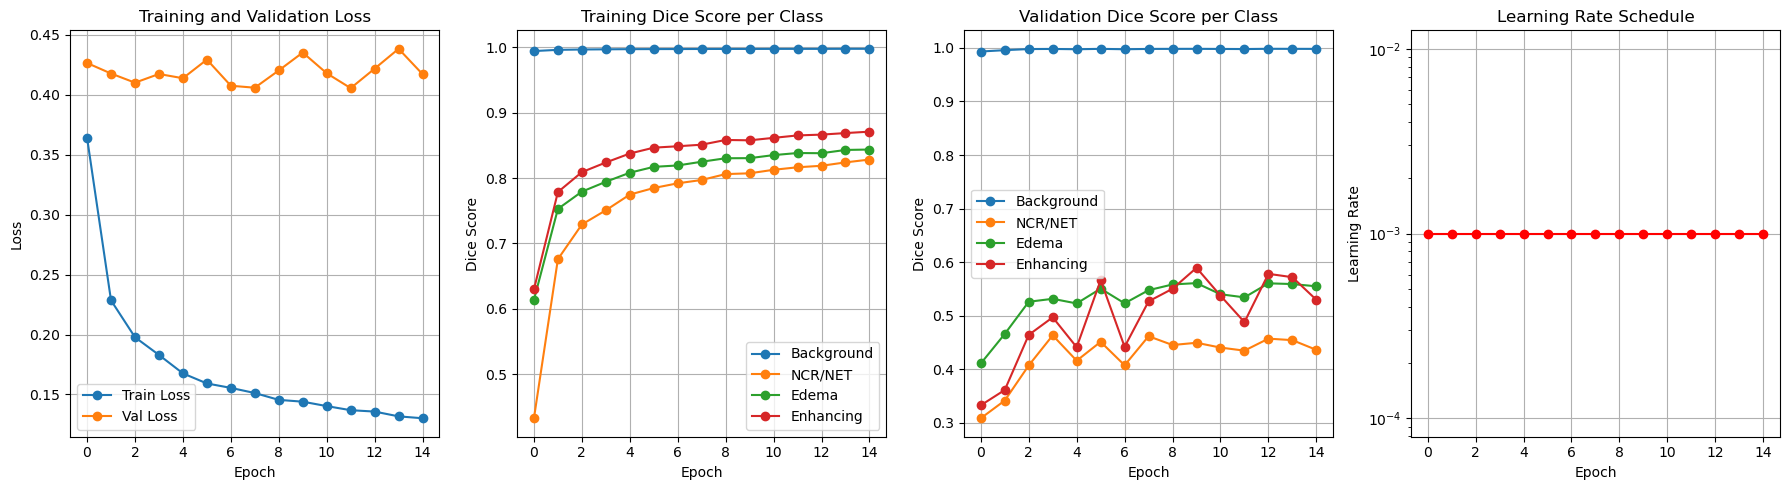

In [17]:
plt.figure(figsize=(18, 5))

# Loss plot
plt.subplot(1, 4, 1)
plt.plot(history['train_loss'], label='Train Loss', marker='o')
plt.plot(history['val_loss'], label='Val Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)

# Training Dice per class
plt.subplot(1, 4, 2)
train_dice_array = np.array(history['train_dice_per_class'])
for c, label in enumerate(['Background', 'NCR/NET', 'Edema', 'Enhancing']):
    plt.plot(train_dice_array[:, c], label=label, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Dice Score')
plt.title('Training Dice Score per Class')
plt.legend()
plt.grid(True)

# Validation Dice per class
plt.subplot(1, 4, 3)
val_dice_array = np.array(history['val_dice_per_class'])
for c, label in enumerate(['Background', 'NCR/NET', 'Edema', 'Enhancing']):
    plt.plot(val_dice_array[:, c], label=label, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Dice Score')
plt.title('Validation Dice Score per Class')
plt.legend()
plt.grid(True)

# *** MODEL 5 NEW ***: Learning rate plot
plt.subplot(1, 4, 4)
plt.plot(history['learning_rates'], marker='o', color='red')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.title('Learning Rate Schedule')
plt.yscale('log')
plt.grid(True)

plt.tight_layout()
plt.savefig('model5_training_history.png', dpi=150)
plt.show()

# Test Set Evaluation (BraTS Competition Metrics)

*** MODEL 5 NEW ***: Evaluating on held-out test set using official BraTS metrics

In [19]:
# Create test dataloader (was missing)
test_dataloader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True,
)

In [21]:
from scipy.ndimage import distance_transform_edt

def compute_hd95(pred, target):
    """Compute 95th percentile Hausdorff Distance"""
    # Handle empty predictions or targets
    if pred.sum() == 0 and target.sum() == 0:
        return 0.0
    if pred.sum() == 0 or target.sum() == 0:
        return np.inf
    
    # Convert to boolean arrays
    pred = pred.astype(bool)
    target = target.astype(bool)
    
    # Get surface points using distance transform
    # Surface = points in mask that are within 1 pixel of background
    pred_border = pred & (distance_transform_edt(~pred) <= 1)
    target_border = target & (distance_transform_edt(~target) <= 1)
    
    # Get coordinates of border points
    pred_pts = np.array(np.where(pred_border)).T
    target_pts = np.array(np.where(target_border)).T
    
    if len(pred_pts) == 0 or len(target_pts) == 0:
        return np.inf
    
    # Compute distances from pred boundary to target
    dt_target = distance_transform_edt(~target_border)
    pred_to_target = dt_target[pred_border]
    
    # Compute distances from target boundary to pred  
    dt_pred = distance_transform_edt(~pred_border)
    target_to_pred = dt_pred[target_border]
    
    # Combine and get 95th percentile
    all_distances = np.concatenate([pred_to_target, target_to_pred])
    hd95 = np.percentile(all_distances, 95)
    
    return hd95

In [22]:
# Load best model for evaluation
testModel = SimpleUNet(in_channels=4, num_classes=4, dropout_rate=0.2)
testModel.load_state_dict(torch.load('model5_best.pth', weights_only=True))
testModel = testModel.to(device)
testModel.eval()

print("Evaluating on test set...")
print(f"Test set size: {len(test_dataset)} slices")
print()

# *** MODEL 5 NEW ***: Compute BraTS metrics on entire test set
all_metrics = {
    'WT_Dice': [], 'TC_Dice': [], 'ET_Dice': [],
    'WT_HD95': [], 'TC_HD95': [], 'ET_HD95': []
}

with torch.no_grad():
    for images, masks in tqdm(test_dataloader, desc="Evaluating test set"):
        images = images.to(device, non_blocking=True)
        
        if use_amp:
            with autocast('cuda'):
                outputs = testModel(images)
        else:
            outputs = testModel(images)
        
        pred_classes = torch.argmax(torch.softmax(outputs, dim=1), dim=1)
        
        # Compute metrics for each sample in batch
        for i in range(pred_classes.shape[0]):
            pred_np = pred_classes[i].cpu().numpy()
            mask_np = masks[i].numpy()
            
            metrics = compute_brats_metrics(pred_np, mask_np)
            for key, value in metrics.items():
                if not np.isinf(value):  # Skip inf values for HD95 when no tumor
                    all_metrics[key].append(value)

# Compute mean metrics
print("\n" + "="*60)
print("TEST SET RESULTS (BraTS Competition Metrics)")
print("="*60)
print()
print("Region     | Dice (mean ± std)      | HD95 (mean ± std)")
print("-" * 60)

for region in ['WT', 'TC', 'ET']:
    dice_values = all_metrics[f'{region}_Dice']
    hd95_values = all_metrics[f'{region}_HD95']
    
    dice_mean = np.mean(dice_values)
    dice_std = np.std(dice_values)
    hd95_mean = np.mean(hd95_values) if len(hd95_values) > 0 else np.inf
    hd95_std = np.std(hd95_values) if len(hd95_values) > 0 else 0
    
    region_name = {'WT': 'Whole Tumor', 'TC': 'Tumor Core', 'ET': 'Enhancing'}[region]
    print(f"{region_name:12} | {dice_mean:.4f} ± {dice_std:.4f}       | {hd95_mean:.2f} ± {hd95_std:.2f}")

print()
print("Note: HD95 is in pixels. Lower is better. Dice is 0-1. Higher is better.")

Evaluating on test set...
Test set size: 8769 slices



Evaluating test set:   0%|          | 0/138 [00:00<?, ?it/s]


TEST SET RESULTS (BraTS Competition Metrics)

Region     | Dice (mean ± std)      | HD95 (mean ± std)
------------------------------------------------------------
Whole Tumor  | 0.6623 ± 0.4082       | 7.02 ± 17.46
Tumor Core   | 0.7016 ± 0.4239       | 4.88 ± 12.55
Enhancing    | 0.7704 ± 0.3919       | 1.54 ± 6.47

Note: HD95 is in pixels. Lower is better. Dice is 0-1. Higher is better.


# Multi-Modality Visualization

*** MODEL 5 NEW ***: Visualize predictions alongside all 4 MRI modalities

Visualizing test set predictions...



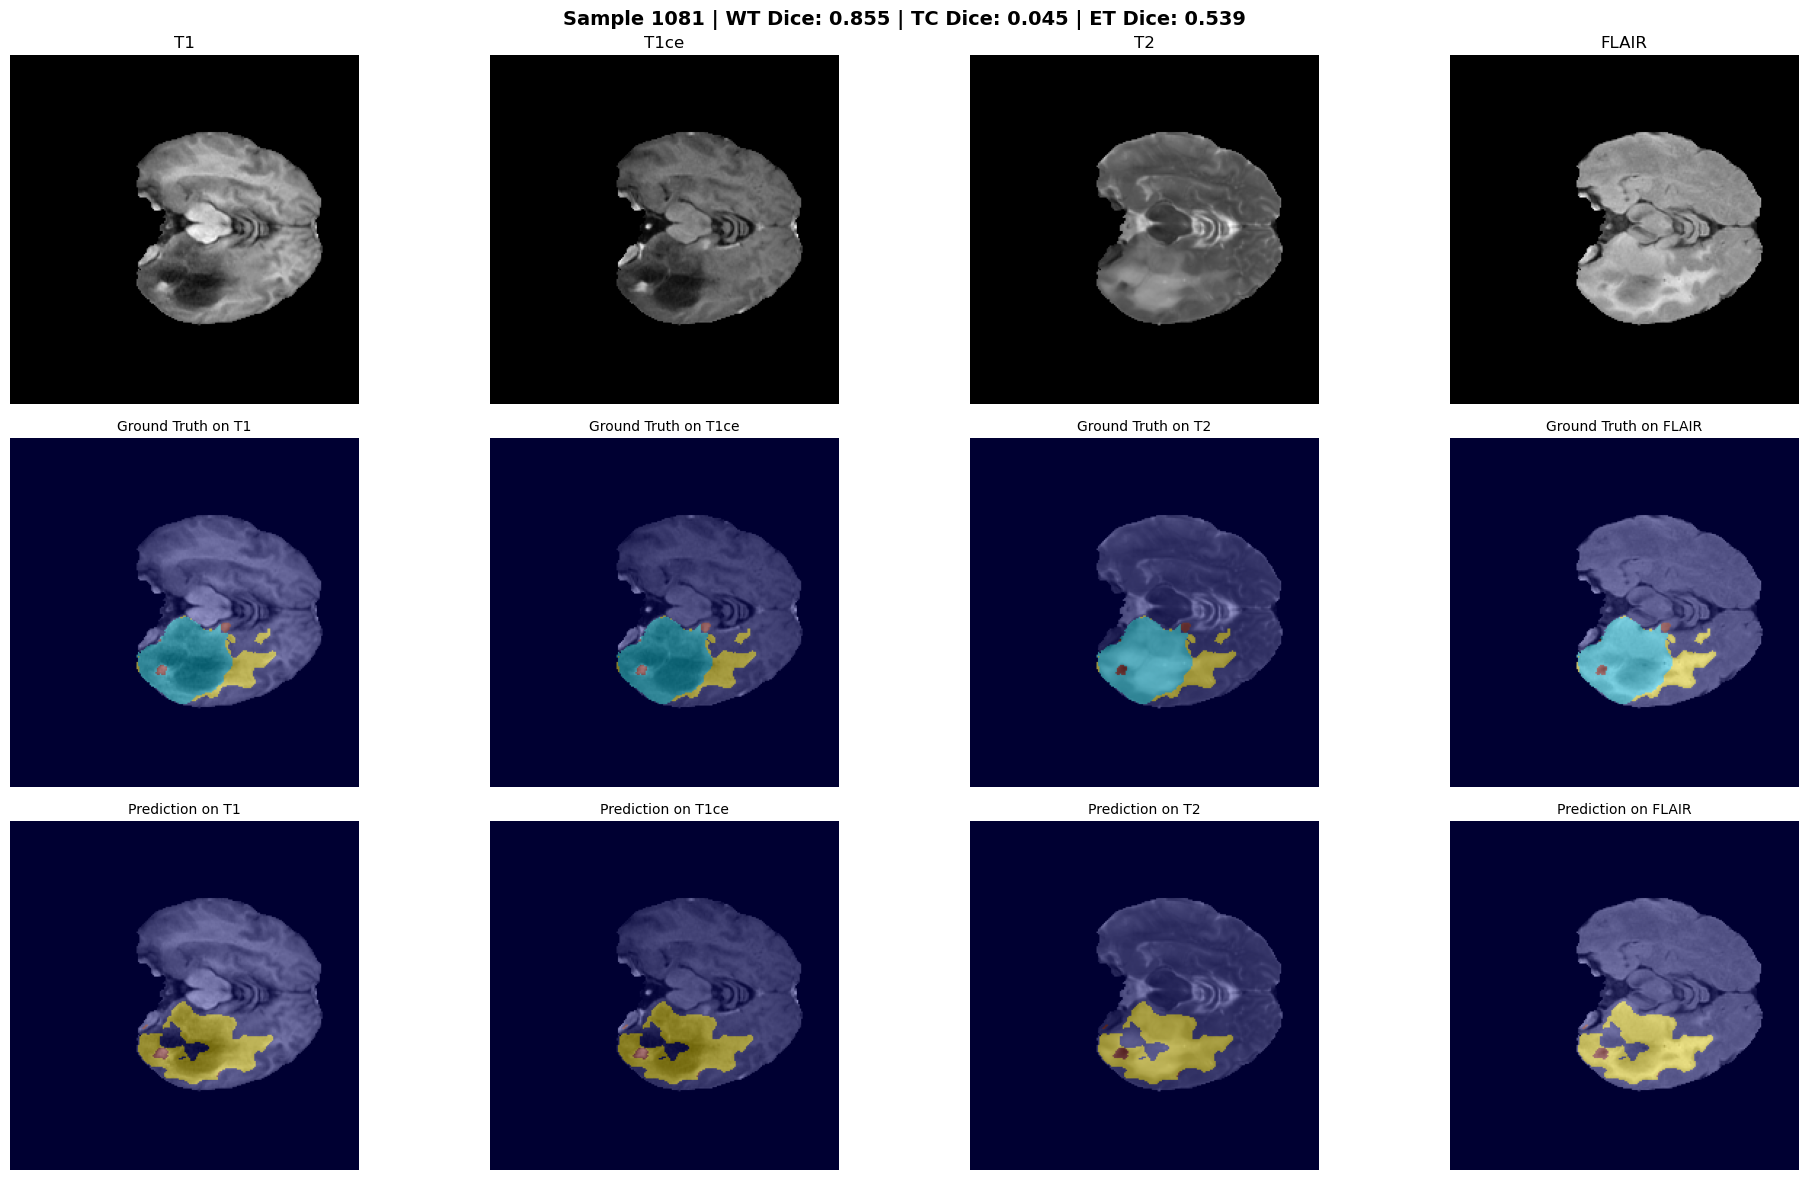

Sample 1081: WT=0.855, TC=0.045, ET=0.539


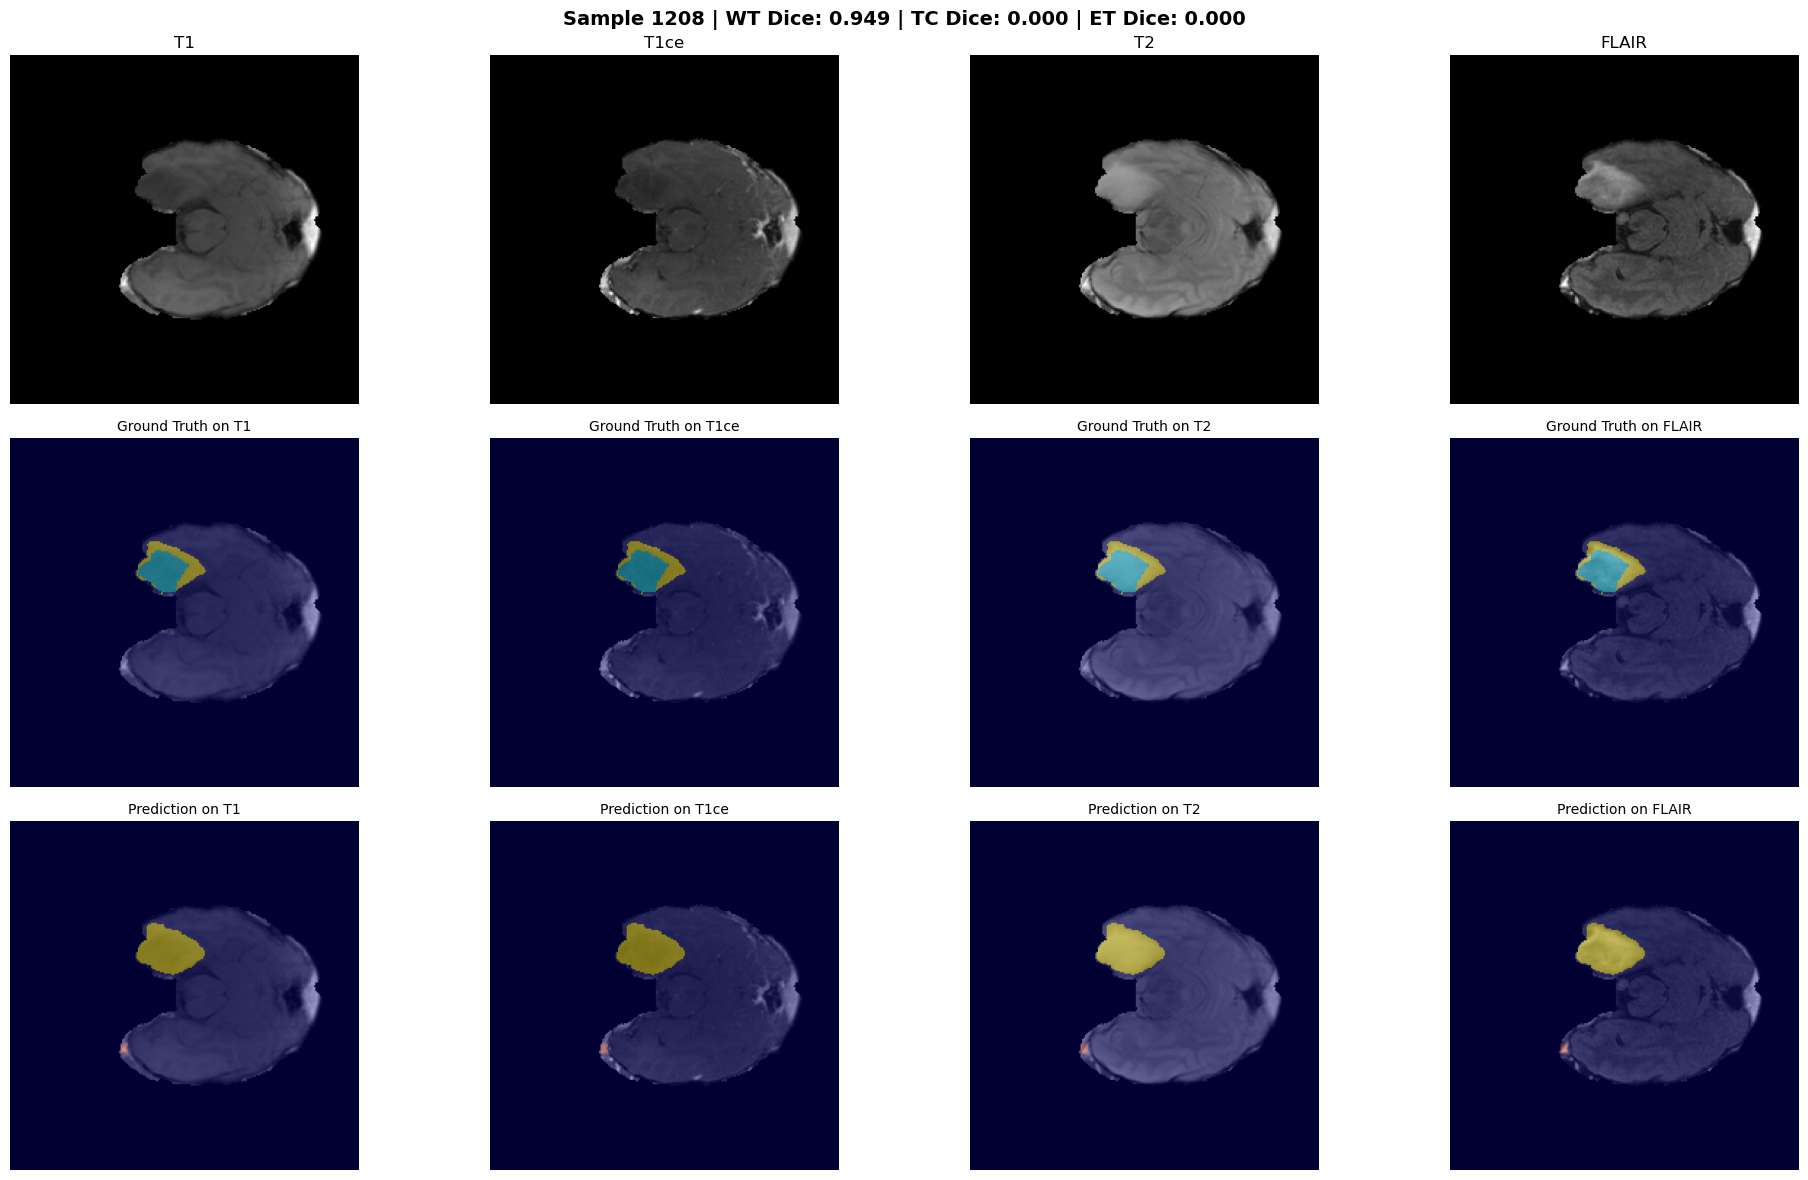

Sample 1208: WT=0.949, TC=0.000, ET=0.000


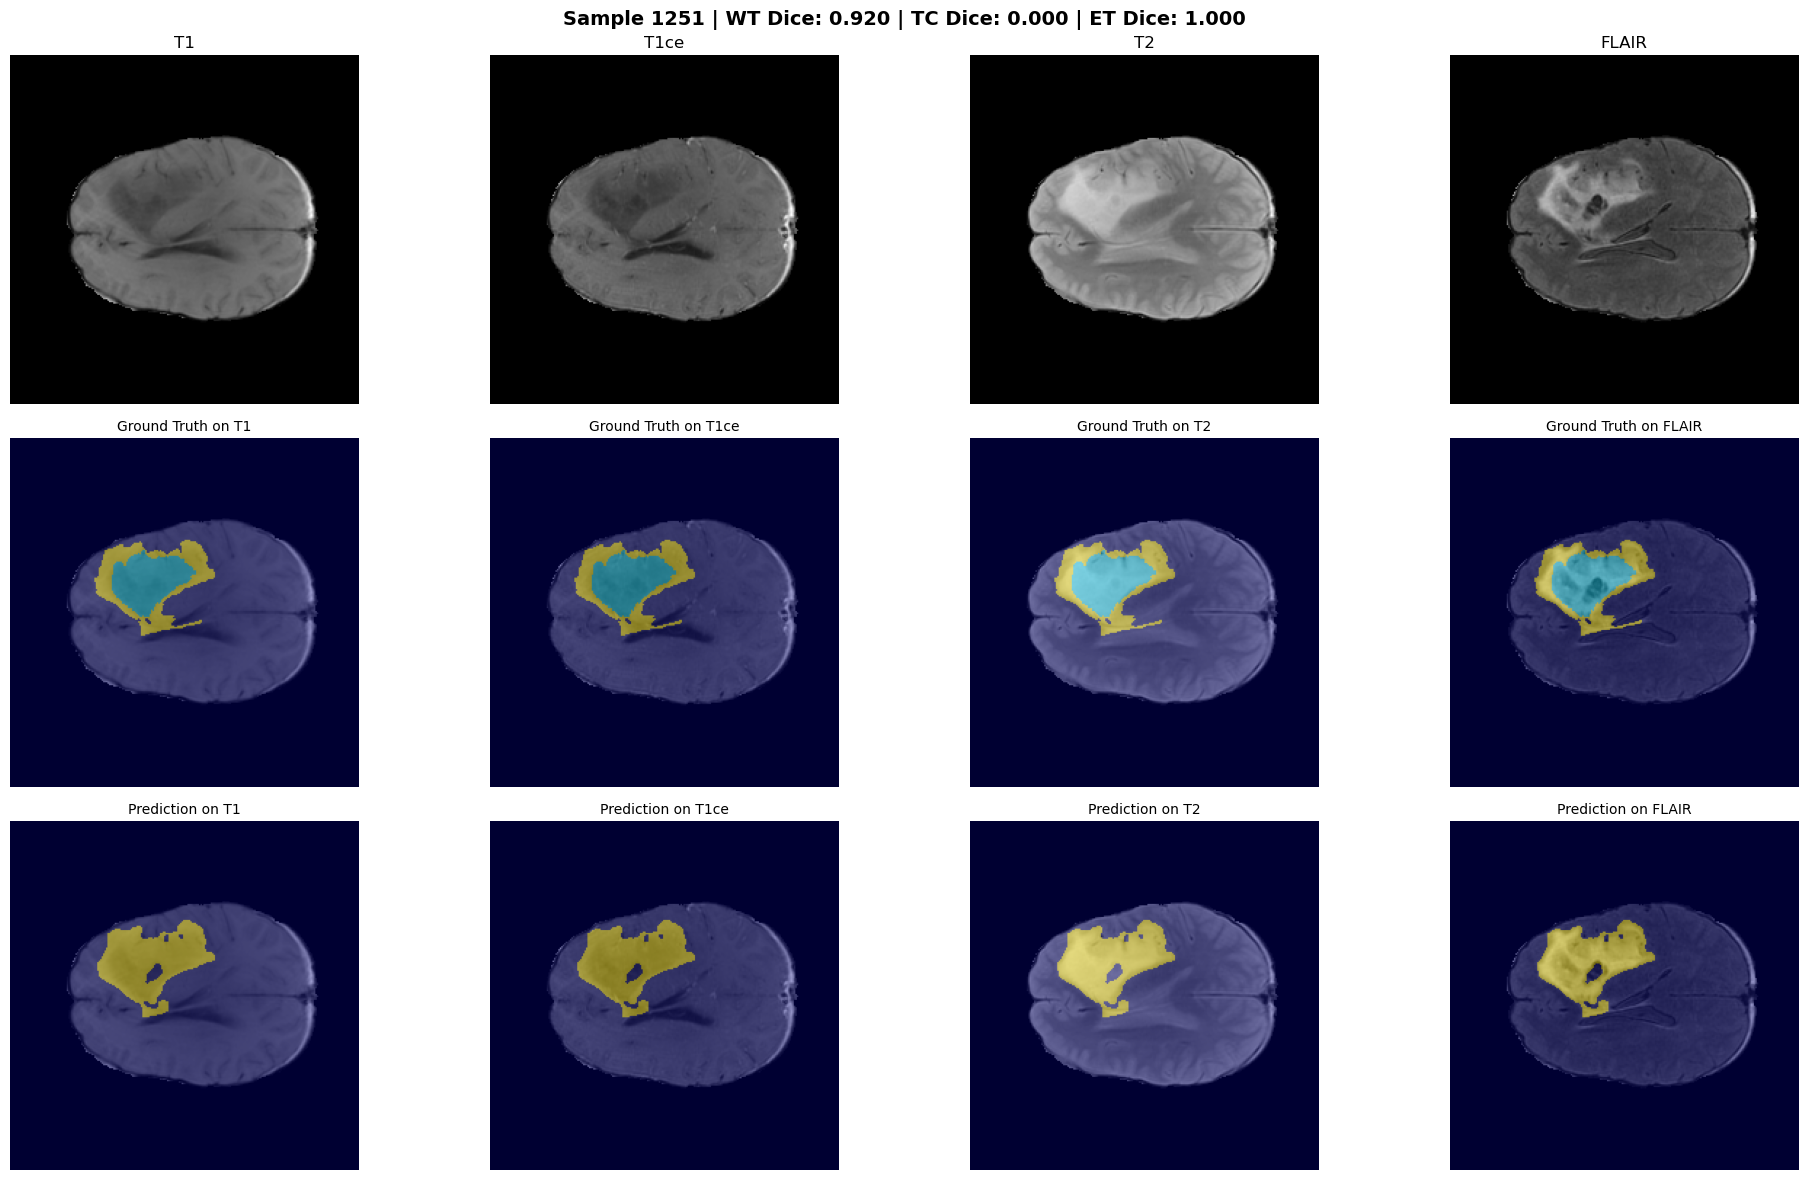

Sample 1251: WT=0.920, TC=0.000, ET=1.000


In [28]:
def visualize_prediction_multimodal(model, dataset, device, idx=0, modalities=['T1', 'T1ce', 'T2', 'FLAIR']):
    """
    *** MODEL 5 NEW ***: Comprehensive visualization with all 4 modalities
    """
    model.eval()
    
    img, mask = dataset[idx]
    input_tensor = img.unsqueeze(0).to(device)
    
    with torch.no_grad():
        if use_amp:
            with autocast('cuda'):
                output = model(input_tensor)
        else:
            output = model(input_tensor)
        pred_probs = torch.softmax(output, dim=1)
        pred_classes = torch.argmax(pred_probs, dim=1)
    
    pred_cpu = pred_classes.squeeze().cpu().numpy()
    img_cpu = img.numpy()
    mask_cpu = mask.numpy()
    
    # Compute BraTS metrics for this sample
    metrics = compute_brats_metrics(pred_cpu, mask_cpu)
    
    # Create figure
    fig = plt.figure(figsize=(20, 12))
    
    # Row 1: All 4 modalities
    for i, mod_name in enumerate(modalities):
        ax = fig.add_subplot(3, 4, i+1)
        ax.imshow(img_cpu[i], cmap='gray')
        ax.set_title(f"{mod_name}", fontsize=12)
        ax.axis('off')
    
    # Row 2: Ground truth overlay on each modality
    for i, mod_name in enumerate(modalities):
        ax = fig.add_subplot(3, 4, i+5)
        ax.imshow(img_cpu[i], cmap='gray')
        ax.imshow(mask_cpu, cmap='jet', alpha=0.4, vmin=0, vmax=3)
        ax.set_title(f"Ground Truth on {mod_name}", fontsize=10)
        ax.axis('off')
    
    # Row 3: Prediction overlay on each modality
    for i, mod_name in enumerate(modalities):
        ax = fig.add_subplot(3, 4, i+9)
        ax.imshow(img_cpu[i], cmap='gray')
        ax.imshow(pred_cpu, cmap='jet', alpha=0.4, vmin=0, vmax=3)
        ax.set_title(f"Prediction on {mod_name}", fontsize=10)
        ax.axis('off')
    
    # Add metrics as text
    fig.suptitle(
        f"Sample {idx} | WT Dice: {metrics['WT_Dice']:.3f} | TC Dice: {metrics['TC_Dice']:.3f} | ET Dice: {metrics['ET_Dice']:.3f}",
        fontsize=14, fontweight='bold'
    )
    
    plt.tight_layout()
    plt.savefig(f'model5_prediction_sample_{idx}.png', dpi=150)
    plt.show()
    
    return metrics

# Visualize a few test samples
print("Visualizing test set predictions...\n")

for idx in [1081, 1208, 1251]:
    try:
        metrics = visualize_prediction_multimodal(testModel, test_dataset, device, idx=idx)
        print(f"Sample {idx}: WT={metrics['WT_Dice']:.3f}, TC={metrics['TC_Dice']:.3f}, ET={metrics['ET_Dice']:.3f}")
    except Exception as e:
        print(f"Sample {idx}: Could not visualize - {e}")

# Next Steps for Model 6:

**Primary Goal: 3D U-Net**
- Move from 2D slices to full 3D volumes
- Capture spatial context across slices
- Standard approach for top BraTS submissions

**Required for 3D:**
- Upgrade to V100 GPU (ml.p3.2xlarge) - needs more memory
- Patch-based training (can't fit full volume in memory)
- Gradient checkpointing to save memory
- New preprocessing for 3D patches

**Other Improvements to Consider:**
- Deeper encoder (more layers)
- Attention mechanisms
- Post-processing (connected component analysis)
- Test-time augmentation
- Ensemble multiple models

**Evaluation Targets:**
Based on BraTS leaderboards, competitive 3D U-Net scores:
- WT Dice: > 0.88
- TC Dice: > 0.80  
- ET Dice: > 0.75

**Still for Future:**
- Transformer-based architectures (UNETR, Swin-UNETR)
- Self-training / pseudo-labeling
- Multi-scale fusion